In [1]:
import os
import librosa
import tensorflow as tf
import numpy as np
from tensorflow.image import resize
import torchaudio
import torch

2024-11-09 12:40:32.063023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 12:40:33.419568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731156034.779222   21935 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731156035.180134   21935 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 12:40:36.840384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [25]:
model = tf.keras.models.load_model("Trained_model.h5")

In [26]:
classes = ['blues','classical','country','disco','hiphop','jazz','metal',
           'pop','reggae','rock']

Single audio preprocessing

In [27]:
def load_and_preprocess_file(file_path, target_shape=(210, 210)):
    data = []
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    chunk_duration = 4
    overlap_duration = 2
    chunk_samples = chunk_duration * sample_rate
    overlap_samples = overlap_duration * sample_rate
    num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
    
    for i in range(num_chunks):
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples
        chunk = audio_data[start:end]
        
        # Convert chunk to Mel Spectrogram
        mel_spectrogram = torchaudio.transforms.MelSpectrogram()(torch.tensor(chunk).unsqueeze(0)).numpy()
        
        # Resize matrix based on provided target shape (210, 210)
        mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
        data.append(mel_spectrogram)
    
    return np.array(data)


In [28]:
file_path="test_data/byebye.mp3"
x_test=load_and_preprocess_file(file_path)

In [29]:
x_test.shape

(13, 1, 210, 210, 1)

In [30]:
x_test=np.squeeze(x_test,axis=1)

In [31]:
x_test.shape

(13, 210, 210, 1)

Model prediction

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def model_prediction_with_pie_chart(x_test, model, genre_labels):
    # Predict probabilities for each class
    y_pred = model.predict(x_test)
    
    # Get the index of the highest probability for each prediction
    predicted_cats = np.argmax(y_pred, axis=1)
    
    # Count the occurrences of each unique predicted category
    unique_elements, counts = np.unique(predicted_cats, return_counts=True)
    
    # Calculate percentages
    percentages = 100 * counts / np.sum(counts)
    
    # Plot a pie chart
    plt.figure(figsize=(7, 7))
    plt.pie(percentages, labels=[genre_labels[i] for i in unique_elements], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title("Prediction Distribution by Genre")
    plt.show()

    # Find the most common category
    most_common_category = unique_elements[np.argmax(counts)]
    
    # Print the predicted categories and the most frequent category
    print(f"Predicted categories: {predicted_cats}")
    print(f"The most frequent predicted category is: {genre_labels[most_common_category]}")
    
    return predicted_cats, most_common_category



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


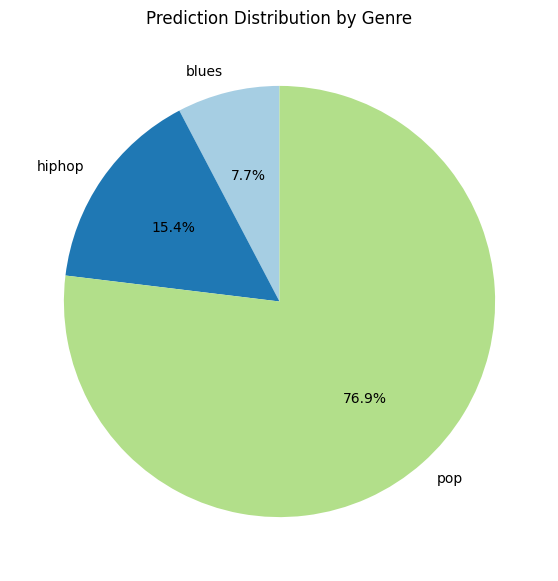

Predicted categories: [4 7 7 7 7 0 7 7 7 7 4 7 7]
The most frequent predicted category is: pop


In [33]:
c_index = model_prediction_with_pie_chart(x_test,model,classes)